In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from impala.dbapi import connect
from impala.util import as_pandas
from tqdm import tqdm_notebook
import matplotlib.pyplot as plt
%matplotlib inline

# Step 1: Get the Data

In [2]:
# In order to access Impala (our database), I created a text file to store my credentials
# so I don't have to expose my login info in my code. 

with open('/users/dowj/impala_creds.txt') as f:
  credentials = [cred.split('\n')[0] for cred in f.readlines()]
# reads the text file with my login info, \n establishes that un/pw are on different lines

host = '104.197.253.59'
port   = 21050
db     = 'investopedia'
user   = credentials[0]
passwd = credentials[1]
# assign database host name, port, and my credentials as variables so the function below can access the database

# Create a function that will execute queries in Impala using Jupyter Notebooks.
def run_query(query):
  
    conn = connect(host=host, port=port, database=db, user=user, password=passwd)
    cur = conn.cursor()

    cur.execute(query)
    df = as_pandas(cur) 

    conn.close()

    return df

#  The .cursor() method used with connect() allows me to run SQL code and 
# .execute() is the equivalent of hitting "execute" in the database. 
# Finally, I store the results as a Pandas data frame (using as_pandas) and close the connection

In [4]:
# this query pulls all subchannels and the number of URLs in each channel
query = """
select  c.primary_sub_channel, count(distinct p.relative_path) as url_count
from content c
left join page_traffic p using (relative_path)
where c.content_type not in('Stock Analysis', 'Syndicated Content', 'Advisor Article', 'Landing', 'Listing', 'uk article','Accounts', 'Corp','Search', 'FA Answer', 'FA Question', 'FA Profile')
and c.primary_sub_channel <> 'NULL'
and c.primary_channel <> 'NULL'
and p.traffic_channel = 'organic search'
and p.traffic_date <> 'NULL'
and p.traffic_date >= '2012-01-01' and p.traffic_date <= '2017-08-31'
group by  c.primary_sub_channel
order by url_count asc
"""

In [5]:
df = run_query(query)

In [7]:
small_sc = df.loc[lambda df: df['url_count'] < 1000, :]
small_sc.head(10)

,primary_sub_channel,url_count
0,Senior Care,9
1,Disability Insurance,9
2,Military / Veterans,9
3,IRAs,12
4,Charity,13
5,Long-Term Care Insurance,13
6,Choosing an Advisor,19
7,Financial Planning,19
8,E-Commerce,31
9,Trading,34


In [8]:
# this query counts urls and sums organic pvs for each subchannel, from 2012-2016 (excluding subchannels with under 1000 urls)
# in the US only
query1 = """
select c.primary_channel, c.primary_sub_channel, count(distinct p.relative_path) as url_count
, date_part('year', p.traffic_date) as traffic_year
, date_part('month', p.traffic_date) as traffic_month
, sum(p.entrances) as org_ents
, c.timelessness
from content c
left join page_traffic p using (relative_path)
where c.content_type not in('Stock Analysis', 'Syndicated Content', 'Advisor Article', 'Landing', 'Listing', 'uk article','Accounts', 'Corp','Search', 'FA Answer', 'FA Question', 'FA Profile')
and c.primary_sub_channel not in ('Senior Care',
'Disability Insurance',
'Military / Veterans',
'IRAs',
'Charity',
'Long-Term Care Insurance',
'Choosing an Advisor',
'Financial Planning',
'E-Commerce',
'Trading',
'401(k)',
'Annuities',
'Marriage / Divorce',
'Social Security',
'Debt',
'Tech',
'Personal Finance',
'Women & Money',
'Children/Family',
'Pensions',
'Exam Prep',
'Tax Deductions / Credits',
'Big Data',
'Estate Planning',
'Virtual Reality',
'Financial Technology',
'Life Insurance',
'Insights',
'Artificial Intelligence',
'College Costs',
'Managing Wealth',
'High Net Worth Living',
'Crime & Fraud',
'Income Tax',
'Health Insurance',
'Robo-Advisor',
'Cybersecurity',
'Asset Allocation',
'Retirement',
'Laws & Regulations',
'Banking',
'Virtual Currency',
'People',
'Alternative Investments',
'Politics & Money',
'Career / Compensation',
'Investing',
'Buzz & Trending',
'Retirement Living'
)
and c.primary_sub_channel <> 'NULL'
and c.primary_channel <> 'NULL'
and c.timelessness not in('Timely', 'NULL') 
and p.country = 'united states'
and p.traffic_channel = 'organic search'
and p.traffic_date <> 'NULL'
and p.traffic_date >= '2012-01-01' and p.traffic_date <= '2017-08-31'
group by c.primary_channel, c.primary_sub_channel, c.timelessness, traffic_month, traffic_year
"""

In [9]:
df1= run_query(query1)

In [10]:
df1.head(10)

,primary_channel,primary_sub_channel,url_count,traffic_year,traffic_month,org_ents,timelessness
0,Insights,Company Insights,33,2012,12,11968,Timeless
1,Trading,Trading Strategy,1146,2012,7,150924,Timeless
2,Investing,Financial Analysis,4594,2013,9,2246561,Timeless
3,Personal Finance,Budgeting & Savings,356,2017,7,111746,Semi-timely
4,Investing,Mutual Funds,103,2013,12,15074,Semi-timely
5,Personal Finance,"Credit, Loans & Mortgages",651,2016,11,102496,Semi-timely
6,Trading,Trading Strategy,399,2016,6,67101,Semi-timely
7,Taxes,Taxes,401,2012,8,81826,Timeless
8,Trading,Chart Strategy,15,2012,4,1540,Semi-timely
9,Trading,Trading Instruments,115,2016,6,38941,Semi-timely


# Step 2: Clean and Explore the Data

In [11]:
# Taking the average entrance count by urls within each subchannel to get a sense of true (or truer) growth within each channel.
# if I only looked at aggregated entrances, subchannels with more URLs may look like they have higher growth than they actually do.
# I also had to convert traffic year to a string, because when I tried to plot it, the years were appearing as 0, 1, 2, 3...
# on the x axis for some reason. 
df1['avg_ents_url'] = df1['org_ents'] / df1['url_count']
df1['avg_ents_url'] = df1['avg_ents_url'].apply(lambda x: round(x))
df1['traffic_year'] = df1['traffic_year'].astype(str)
df1.head(5)

,primary_channel,primary_sub_channel,url_count,traffic_year,traffic_month,org_ents,timelessness,avg_ents_url
0,Insights,Company Insights,33,2012,12,11968,Timeless,363
1,Trading,Trading Strategy,1146,2012,7,150924,Timeless,132
2,Investing,Financial Analysis,4594,2013,9,2246561,Timeless,489
3,Personal Finance,Budgeting & Savings,356,2017,7,111746,Semi-timely,314
4,Investing,Mutual Funds,103,2013,12,15074,Semi-timely,146


In [12]:
pivot_df= df1.pivot_table(index=['traffic_year','traffic_month'], columns='primary_channel', values= 'avg_ents_url', aggfunc='sum')

In [13]:
pivot_df.head()

primary_channel             Financial Advisor  Insights  Insurance  Investing  \
traffic_year traffic_month                                                      
2012         1                           1666       914        471       5381   
             2                           1645      1075        475       6250   
             3                           1456       998        489       5922   
             4                           1410      1165        542       5766   
             5                           1365      1061        567       5921   

primary_channel             Managing Wealth  Personal Finance  Retirement  \
traffic_year traffic_month                                                  
2012         1                          542               652         750   
             2                          637               641         856   
             3                          632               659         853   
             4                          725               774         903   
             5                          595               790         547   

primary_channel             Small Business  Taxes  Trading  
traffic_year traffic_month                                  
2012         1                         643    709     1479  
             2                         677    807     1624  
             3                         689    741     1503  
             4                         809    827     1433  
             5                         682    505     1466

# Question 1: What are the top two channels on Investopedia?
Answer: In terms of average organic entrances, the clear winner is Investing, followed by Trading, though they have very different trends. This raises further questions. First we will investigate what's happening with the Investing channel, and why there seems to be a downward trend happening (are there subchannels dragging it down, or is the decline across all subchannels?). 

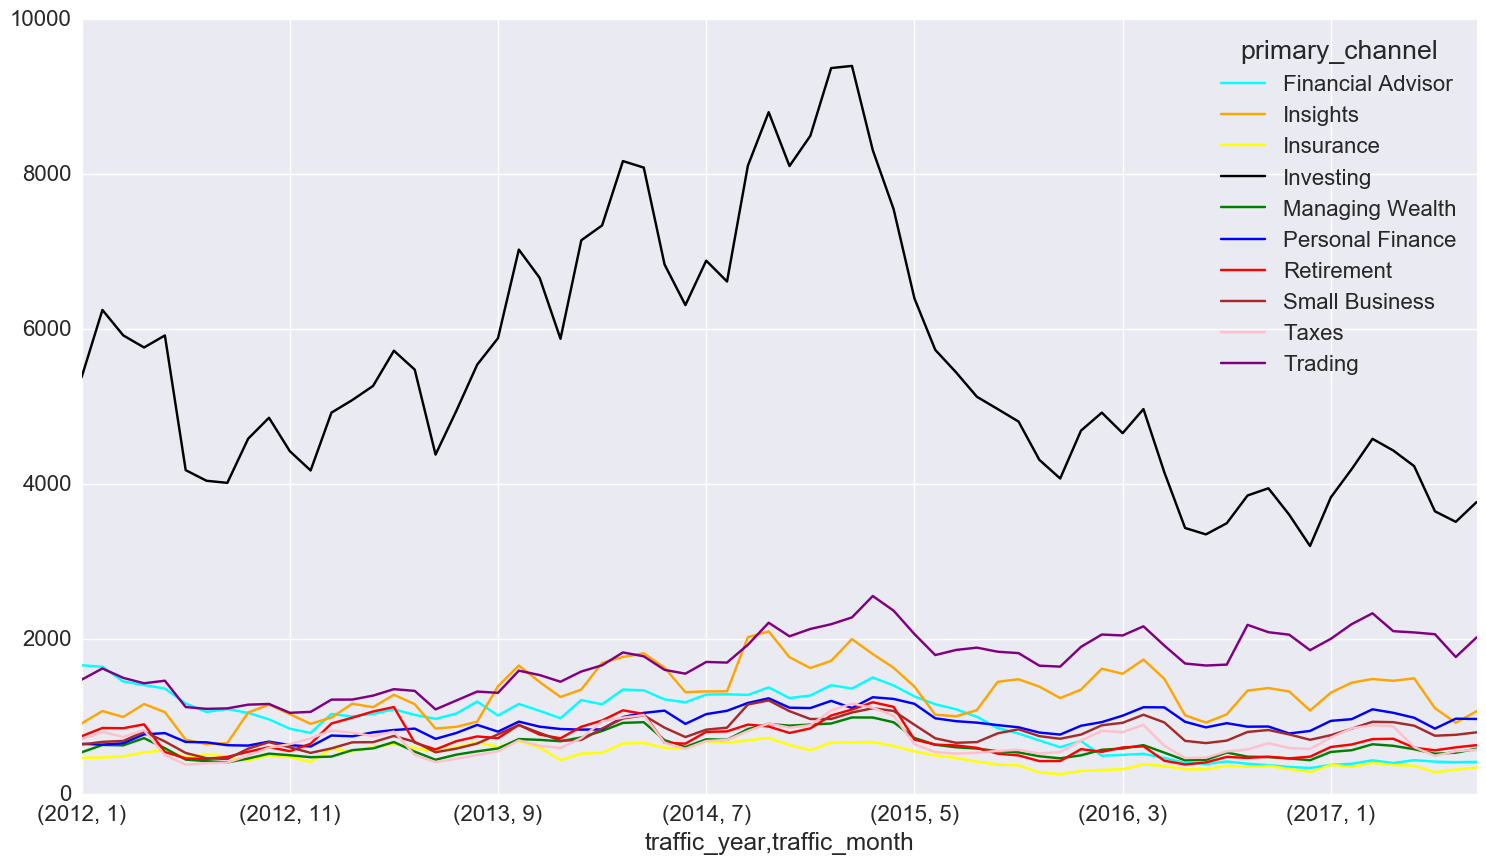

In [14]:
pivot_df.plot(figsize=(18,10),color={'blue','green','black','red','yellow','cyan','magenta','purple','orange','brown','pink'})

In [15]:
# taking a subset of the original data base to hone in on Investing Channel
df_inv = df1[df1['primary_channel'] == 'Investing']
df_inv.groupby('primary_sub_channel')

In [16]:
pivot_invest= df_inv.pivot_table(index=['traffic_year','traffic_month'], columns='primary_sub_channel', values= 'avg_ents_url', aggfunc='sum')

In [17]:
pivot_invest.head()

primary_sub_channel         Bonds / Fixed Income  Commodities  ETFs  \
traffic_year traffic_month                                            
2012         1                               570          246   255   
             2                               667          303   293   
             3                               634          306   300   
             4                               607          250   264   
             5                               536          214   221   

primary_sub_channel         Financial Analysis  International / Global  \
traffic_year traffic_month                                               
2012         1                             733                     254   
             2                             904                     326   
             3                             815                     321   
             4                             833                     458   
             5                             705                     476   

primary_sub_channel         Investing Strategy  Mutual Funds  Real Estate  \
traffic_year traffic_month                                                  
2012         1                             506           411          688   
             2                             597           455          703   
             3                             589           453          681   
             4                             571           444          742   
             5                             533           399          755   

primary_sub_channel         Stocks  
traffic_year traffic_month          
2012         1                1718  
             2                2002  
             3                1823  
             4                1597  
             5                2082

# Question 2: Of the top channels, what are the sub-channels driving traffic?
...Or in this case, what are the sub-channels dragging down growth? The anser seems to clearly be our Stocks channel. It had signficant growth from 2012 to 2014 (minus the brief dip) and fell off a cliff toward the end of 2014. Given that Stocks is one of our oldest and largest sub-channels (in terms of URL count) it is concerning--almost baffling-- to see that Bonds, Real Estate, and Financial Analysis are now surpassing it in terms of average organic entrances per url. To go back to the initial hypthesis-- that our site reflects trends happening in the financial world-- I will look at market volatility, or VIX data. Could it be that lack of volatility in the market translates to lack of interest in stock educational content?  

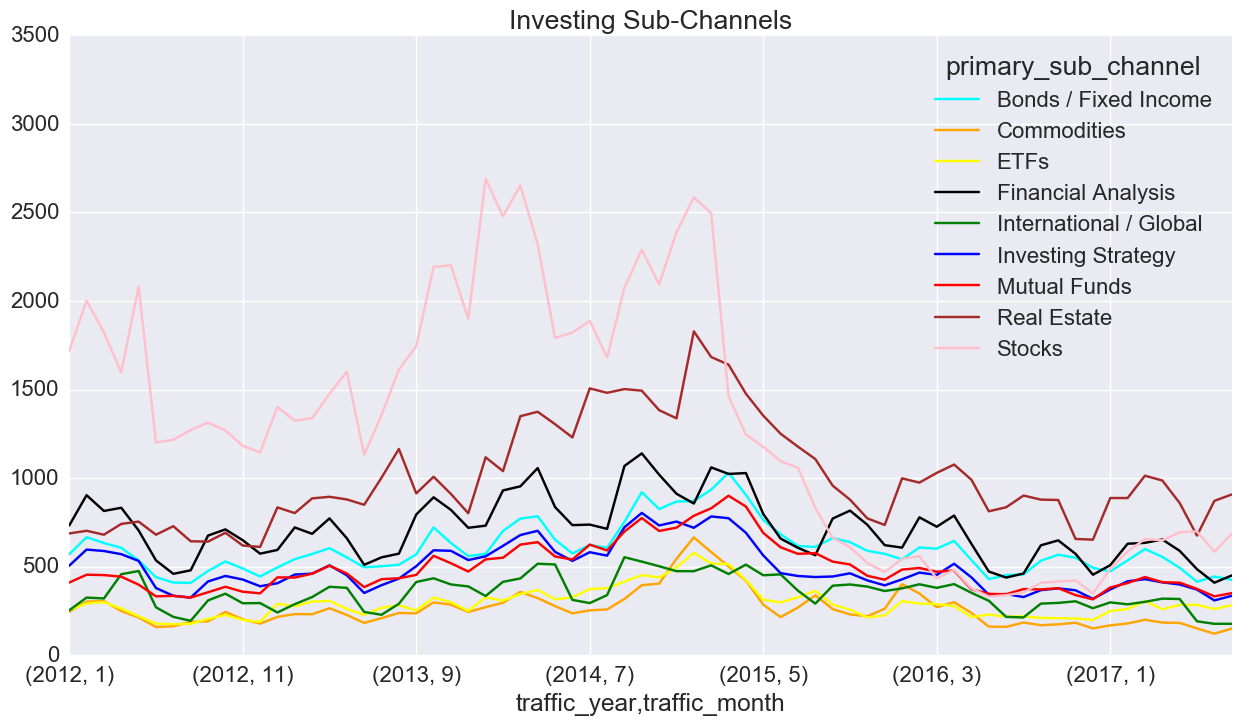

In [18]:
pivot_invest.plot(figsize=(15,8), ylim=(0,3500), title= 'Investing Sub-Channels', color={'blue','green','black','red','yellow','cyan','magenta','purple', 'orange','pink','brown'})

In [75]:
# Now to pull JUST stocks with date time so I can merge with the vix data
query2 = """ select  p.traffic_date as dates
, count(distinct p.relative_path) as url_count
, sum(p.entrances) as org_ents
from content c
left join page_traffic p using (relative_path)
where c.content_type not in('Stock Analysis', 'Syndicated Content', 'Advisor Article', 'Landing', 'Listing', 'uk article','Accounts', 'Corp','Search', 'FA Answer', 'FA Question', 'FA Profile')
and c.primary_sub_channel = 'Stocks'
and c.primary_sub_channel <> 'NULL'
and c.primary_channel <> 'NULL'
and c.timelessness not in('Timely', 'NULL') 
and p.country = 'united states'
and p.traffic_channel = 'organic search'
and p.traffic_date <> 'NULL'
and p.traffic_date >= '2012-01-01' and p.traffic_date <= '2017-08-31'
group by dates"""
df_stocks= run_query(query2)

In [113]:
# calculate average organic entrances, and set the index as dates. Note this data is now daily.
df_stocks['avg_ents_url'] = df_stocks['org_ents'] / df_stocks['url_count']
df_stocks['avg_ents_url'] = df_stocks['avg_ents_url'].apply(lambda x: round(x))
df_stocks = df_stocks.set_index(pd.DatetimeIndex(df_stocks['dates'])).sort_index(ascending = True)
df_stocks.head(5)

,dates,url_count,org_ents,avg_org_ents,avg_ents_url
2012-01-01,2012-01-01,37,353,9.540541,10
2012-01-02,2012-01-02,39,701,17.974359,18
2012-01-03,2012-01-03,48,1452,30.250000,30
2012-01-04,2012-01-04,43,1368,31.813953,32
2012-01-05,2012-01-05,43,1498,34.837209,35


In [114]:
# I then downloaded daily VIX data going back to 2012, and also set the date as index so I can easily merge
df_vix = pd.read_csv('vixcurrent.csv')
df_vix = pd.DataFrame(df_vix)
df_vix = df_vix.set_index(pd.DatetimeIndex(df_vix['Date'])).sort_index(ascending = True)
df_vix.head(5)

,Date,VIX Open,VIX High,VIX Low,VIX Close
2012-01-03,1/3/2012,22.95,23.10,22.54,22.97
2012-01-04,1/4/2012,23.44,23.73,22.22,22.22
2012-01-05,1/5/2012,22.75,23.09,21.34,21.48
2012-01-06,1/6/2012,21.24,21.72,20.58,20.63
2012-01-09,1/9/2012,21.67,21.78,21.00,21.07


In [115]:
# merged both datasets. I had to use left_index AND right_index to align datapoints properly
stocks_vix = pd.merge(df_stocks, df_vix, how= 'left' , left_on ='dates', right_on = 'Date', left_index = True, right_index = True)
stocks_vix.head(5)

,dates,url_count,org_ents,avg_org_ents,avg_ents_url,Date,VIX Open,VIX High,VIX Low,VIX Close
2012-01-01,2012-01-01,37,353,9.540541,10,NaN,NaN,NaN,NaN,NaN
2012-01-02,2012-01-02,39,701,17.974359,18,NaN,NaN,NaN,NaN,NaN
2012-01-03,2012-01-03,48,1452,30.250000,30,1/3/2012,22.95,23.10,22.54,22.97
2012-01-04,2012-01-04,43,1368,31.813953,32,1/4/2012,23.44,23.73,22.22,22.22
2012-01-05,2012-01-05,43,1498,34.837209,35,1/5/2012,22.75,23.09,21.34,21.48


# Question 3: Do trends happening in the Stock Channel reflect market data?
The answer is maybe...

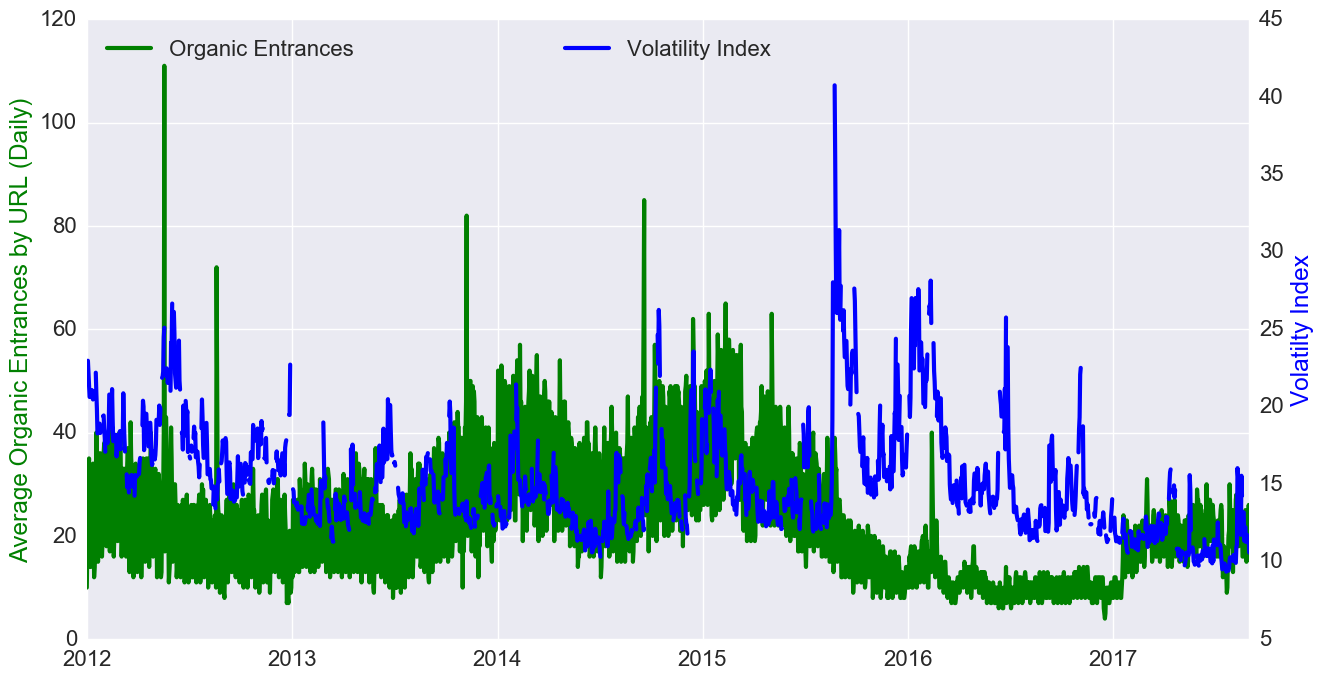

In [116]:
fig, ax = plt.subplots(1, figsize=(15, 8))

stocks_vix['avg_ents_url'].plot( ax=ax, color= 'g', linewidth = 3)
ax.set_ylabel('Average Organic Entrances by URL (Daily)', color = 'g')

ax1 = ax.twinx()
stocks_vix['VIX Close'].plot( ax = ax1, color = 'b', linewidth = 3)
ax1.set_ylabel('Volatilty Index', color = 'b')
ax1.yaxis.grid(False)

ax1.legend(['Volatility Index'], loc = 'upper center')
ax.legend(['Organic Entrances'], loc = 'upper left')

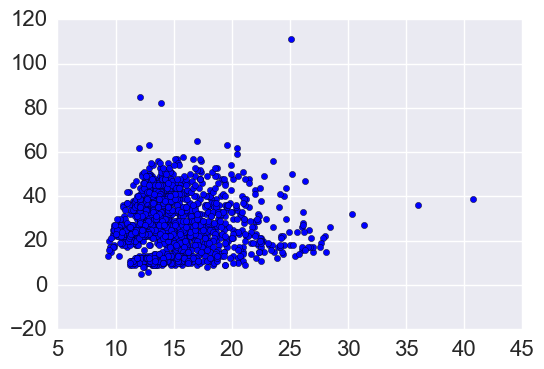

In [117]:
# I wanted to do a bestfit line, but could not due to the NAs in the VIX data set.
x= stocks_vix['VIX Close']
y= stocks_vix['avg_ents_url']
plt.scatter(x,y)

plt.show()

In [122]:
stocks_vix[['avg_ents_url','VIX Close']].corr()

,avg_ents_url,VIX Close
avg_ents_url,1.000000,-0.007371
VIX Close,-0.007371,1.000000


# Conclusion & Further Analysis
There seems to be a statistically significant correlation between these two data sets, suggesting perhaps that less volatility in the stock market means less people are trying to learn about stocks. Still, this analysis is far from conclusive. I would say we are scraping the surface, and proving that there is a relationship worth investigating between our content's performance, and the goings on of the financial world. There are many different avenues to go from here, to name a few:
    1) Are there possible internal causes of the traffic decline, that may be loosely related to the lack of volatility in recent years? For example, could the sudden dip in our stock channel have more to do with rank loss on key terms? To answer this we would have to look at average organic rank changes over time to see if the decline is simply due to decay.
    2) What are the main pieces of content that were driving traffic in 2014/2015? Doing a URL analysis of the Stock channel would give us more insight into what content contributed to the surge and fall. 
    3) Lastly, I think there could be more intense statstical analysis on the two data sets if they are both aggregated up to the monthly level. When merged with the stock data, the VIX data set had NULLs on weekends due to the market closing. Having NaNs lends some innacuracy to the analysis. Also, for a more apples to apples comparison, these could be adjusted to account for the fact that our data lags market data.